In [55]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt


print(torch.__version__)

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(device)

2.4.1
mps


In [56]:
# Setup training data
train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

# Setup test data
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [57]:
train_data, test_data, len(train_data), len(test_data)

(Dataset MNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor(),
 60000,
 10000)

In [58]:
train_data[0][0].shape

torch.Size([1, 28, 28])

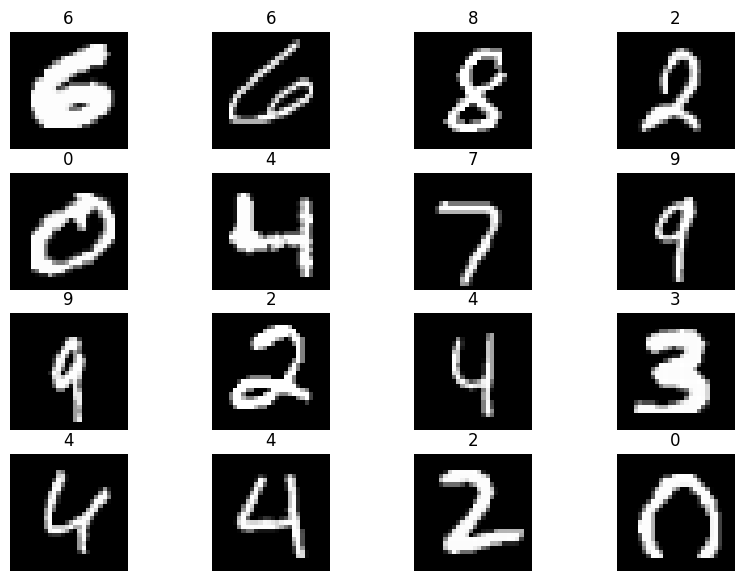

In [59]:
torch.manual_seed(42)

rows = 4
cols = 4
plt.figure(figsize=(10,7))
for i in range(1, rows*cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    X, y = train_data[random_idx]
    plt.subplot(rows, cols, i)
    plt.imshow(X.squeeze(), cmap="gray")
    plt.axis('off')
    plt.title(y)

In [60]:
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [61]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [62]:
# Setup dataloader
train_dataLoader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
test_dataLoader = torch.utils.data.DataLoader(test_data, batch_size=32)

In [63]:
train_dataLoader, test_dataLoader

(<torch.utils.data.dataloader.DataLoader at 0x2c232f200>,
 <torch.utils.data.dataloader.DataLoader at 0x14fc494c0>)

In [64]:
next(iter(train_dataLoader))[0].shape, next(iter(train_dataLoader))[1].shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [71]:
class MNIST_Model_V0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int, device: torch.device = device):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=output_shape,
                      kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,
                      kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,
                      kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,
                      kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, out_features=output_shape))

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x
    
torch.manual_seed(42)
model = MNIST_Model_V0(input_shape=1, hidden_units=10, output_shape=10).to(device)
model

MNIST_Model_V0(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [72]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [73]:
def accuracy_fn(y_true, y_pred):
    correct_predictions = torch.eq(y_true, y_pred).sum()
    accuracy = correct_predictions / len(y_pred)
    return accuracy

In [74]:
# Create sample true labels and predicted labels
y_true = torch.tensor([0, 1, 2, 3, 4])
y_pred_correct = torch.tensor([0, 1, 2, 3, 4])  # All predictions are correct
y_pred_incorrect = torch.tensor([0, 0, 2, 3, 4])  # One prediction is incorrect

# Test the accuracy function with correct predictions
accuracy_correct = accuracy_fn(y_true, y_pred_correct)
print(f"Accuracy with correct predictions: {accuracy_correct.item() * 100:.2f}%")

# Test the accuracy function with incorrect predictions
accuracy_incorrect = accuracy_fn(y_true, y_pred_incorrect)
print(f"Accuracy with incorrect predictions: {accuracy_incorrect.item() * 100:.2f}%")

Accuracy with correct predictions: 100.00%
Accuracy with incorrect predictions: 80.00%


In [75]:
def train_step(model: torch.nn.Module,
               dataLoader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    
    train_loss, acc = 0, 0
    model.to(device)
    model.train()
    for X, y in dataLoader:
        X, y = X.to(device), y.to(device)
        y_logit = model(X)
        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
        loss = loss_fn(y_logit, y)
        train_loss += loss
        acc += accuracy_fn(y, y_pred)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(dataLoader)
    acc /= len(dataLoader)

    print(f"Train Loss {train_loss:.5f} acc {acc:.2f}%")

def test_step(model: torch.nn.Module,
              dataLoader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    
    loss, acc = 0, 0
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for X, y in dataLoader:
            X, y = X.to(device), y.to(device)
            y_logit = model(X)
            y_pred = torch.softmax(y_logit, dim = 1).argmax(dim=1)
            loss += loss_fn(y_logit, y)
            acc += accuracy_fn(y, y_pred)

        loss /= len(dataLoader)
        acc /= len(dataLoader)

    print(f"Test Loss {loss:.5f} acc {acc:.2f}%")


In [76]:
from tqdm import tqdm

epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch}\n------")
    train_step(model=model,
               dataLoader=train_dataLoader,
               loss_fn=loss_fn,
               accuracy_fn=accuracy_fn,
               optimizer=optimizer)
    test_step(model=model,
              dataLoader=test_dataLoader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn)


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0
------
Train Loss 0.27248 acc 0.91%


 33%|███▎      | 1/3 [00:07<00:15,  7.56s/it]

Test Loss 0.08309 acc 0.97%
Epoch 1
------
Train Loss 0.06951 acc 0.98%


 67%|██████▋   | 2/3 [00:15<00:07,  7.51s/it]

Test Loss 0.04798 acc 0.98%
Epoch 2
------
Train Loss 0.05550 acc 0.98%


100%|██████████| 3/3 [00:22<00:00,  7.49s/it]

Test Loss 0.04424 acc 0.98%


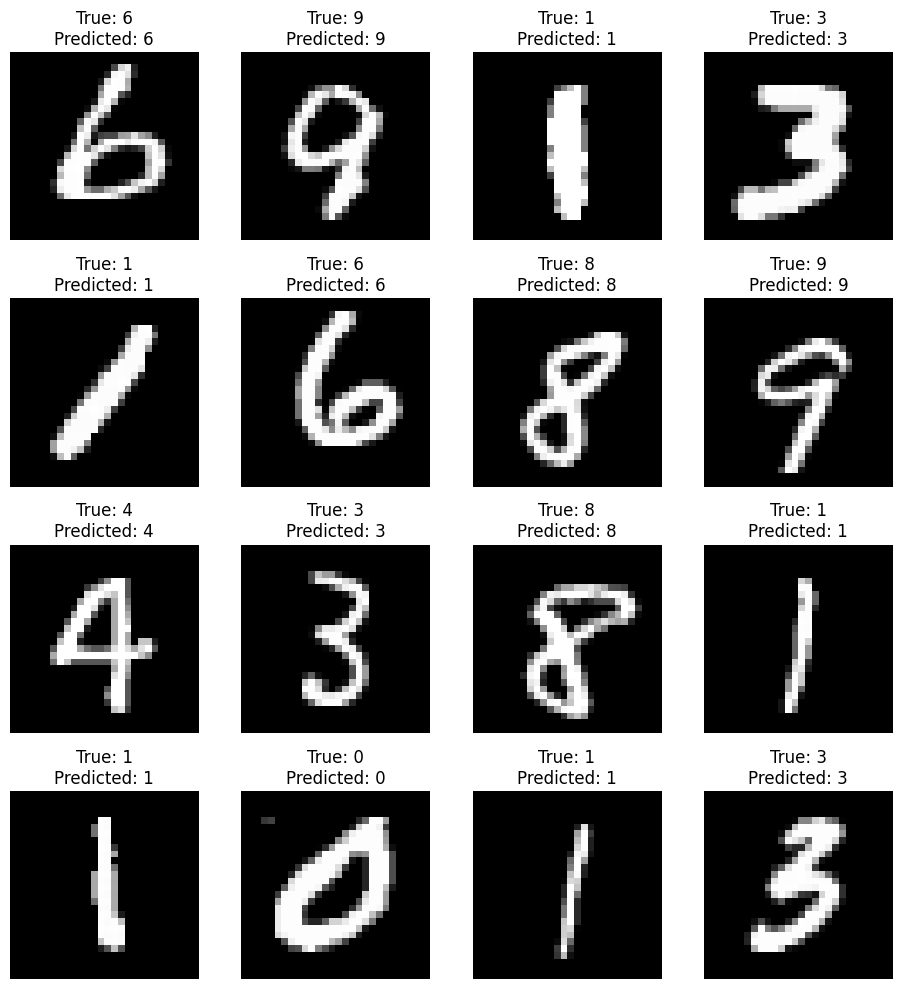

In [87]:
rows, cols = 4, 4
fig = plt.figure(figsize=(10,10))

model.eval()

with torch.inference_mode():
    for i in range(1, rows*cols + 1):
        random_idx = torch.randint(0, len(test_data), size=[1]).item()
        X, y = test_data[random_idx]
        X = X.to(device)
        y_logits = model(X.unsqueeze(dim=0))
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
        
        fig.add_subplot(rows, cols, i)
        plt.imshow(X.to("cpu").squeeze(), cmap="gray")
        title_text = f"True: {y}\nPredicted: {y_pred.item()}"
        plt.title(title_text)
        plt.axis("off");
        plt.tight_layout();



In [78]:
test_data[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [88]:
from tqdm.auto import tqdm

y_preds = []
model.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataLoader, desc="Making predictions"):
        X, y = X.to(device), y.to(device)
        y_logit = model(X)
        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
        y_preds.append(y_pred.cpu())

y_pred_tensor = torch.cat(y_preds)

Making predictions: 100%|██████████| 313/313 [00:00<00:00, 495.89it/s]


In [89]:
y_pred_tensor.shape

torch.Size([10000])

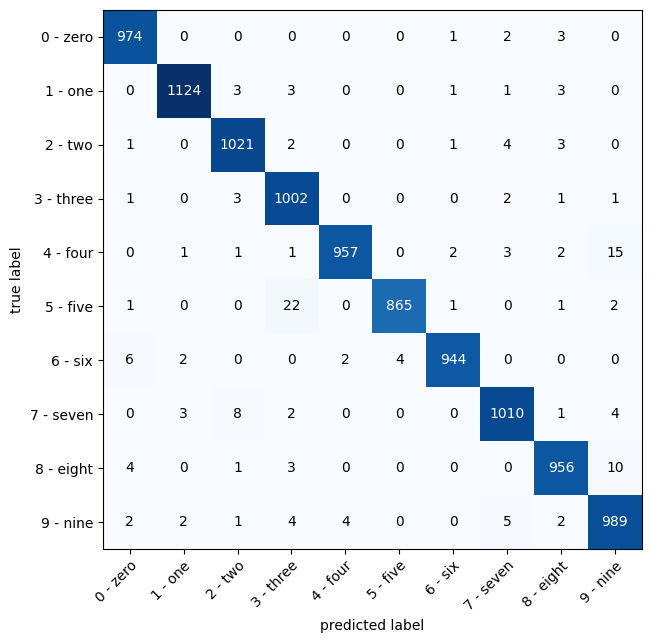

In [90]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor, target=test_data.targets)

fig, ax = plot_confusion_matrix(
    conf_mat = confmat_tensor.numpy(),
    class_names = class_names,
    figsize = (18,7)
);

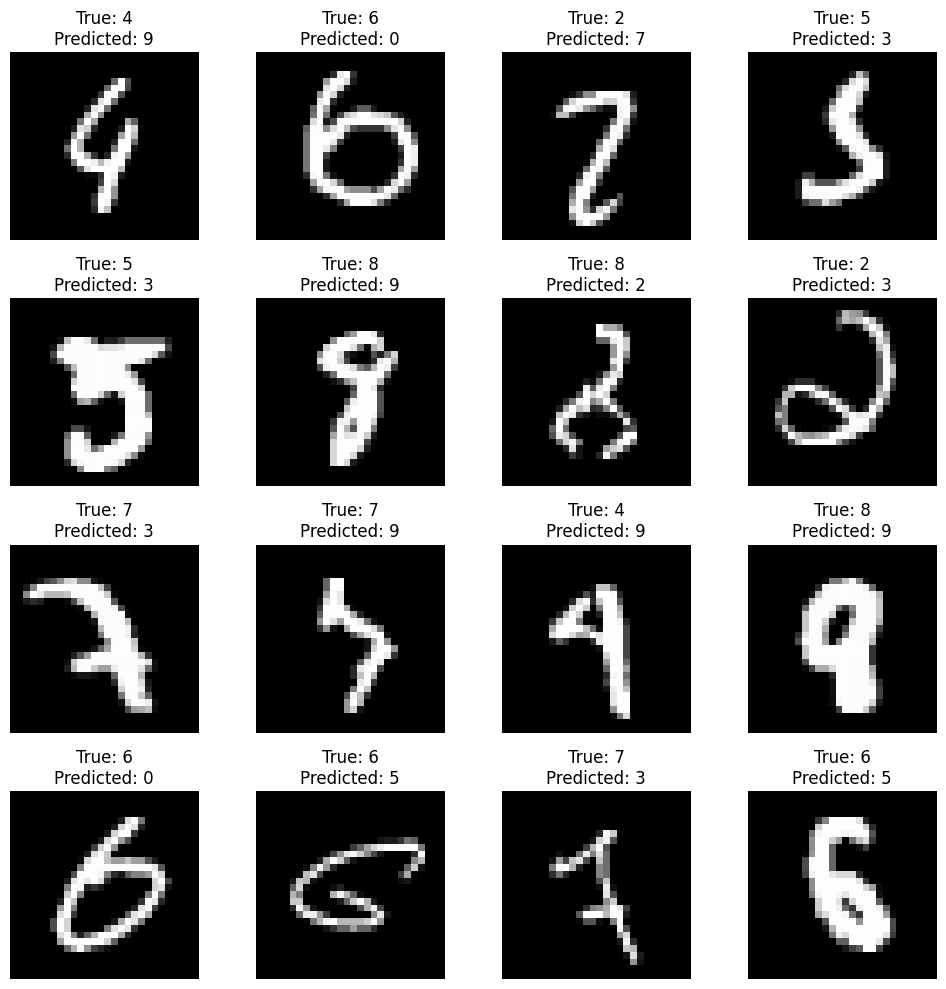

In [91]:
rows, cols = 4, 4
fig = plt.figure(figsize=(10, 10))

model.eval()

incorrect_preds = []

with torch.inference_mode():
    for i in range(len(test_data)):
        X, y = test_data[i]
        X = X.to(device)
        y_logits = model(X.unsqueeze(dim=0))
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
        
        if y_pred.item() != y:
            incorrect_preds.append((X, y, y_pred.item()))
        
        if len(incorrect_preds) >= rows * cols:
            break

for i, (X, y, y_pred) in enumerate(incorrect_preds, 1):
    fig.add_subplot(rows, cols, i)
    plt.imshow(X.to("cpu").squeeze(), cmap="gray")
    title_text = f"True: {y}\nPredicted: {y_pred}"
    plt.title(title_text)
    plt.axis("off")

plt.tight_layout()
plt.show()